初始化⽅案的选择在神经⽹络学习中起着举⾜轻重的作⽤，它对保持数值稳定性⾄关重要。此外，
这些初始化⽅案的选择可以与⾮线性激活函数的选择有趣的结合在⼀起。我们选择哪个函数以及如何初始化
参数可以决定优化算法收敛的速度有多快。             

考虑一个具有$L$层、输入$\mathbf{x}$和输出$\mathbf{o}$的深层网络。
每一层$l$由变换$f_l$定义，
该变换的参数为权重$\mathbf{W}^{(l)}$，
其隐藏变量是$\mathbf{h}^{(l)}$（令 $\mathbf{h}^{(0)} = \mathbf{x}$）。
我们的网络可以表示为：

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ 因此 } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x}).$$

如果所有隐藏变量和输入都是向量，
我们可以将$\mathbf{o}$关于任何一组参数$\mathbf{W}^{(l)}$的梯度写为下式：

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=}}.$$

换言之，该梯度是$L-l$个矩阵
$\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$
与梯度向量 $\mathbf{v}^{(l)}$的乘积。
因此，我们容易受到数值下溢问题的影响.
当将太多的概率乘在一起时，这些问题经常会出现。
在处理概率时，一个常见的技巧是切换到对数空间，
即将数值表示的压力从尾数转移到指数。
不幸的是，上面的问题更为严重：
最初，矩阵 $\mathbf{M}^{(l)}$ 可能具有各种各样的特征值。
他们可能很小，也可能很大；
他们的乘积可能非常大，也可能非常小。

不稳定梯度带来的风险不止在于数值表示；
不稳定梯度也威胁到我们优化算法的稳定性。
我们可能面临一些问题。
要么是*梯度爆炸*（gradient exploding）问题：
参数更新过大，破坏了模型的稳定收敛；
要么是*梯度消失*（gradient vanishing）问题：
参数更新过小，在每次更新时几乎不会移动，导致模型无法学习。

# 梯度消失
曾经sigmoid函数$1/(1 + \exp(-x))$很流行，因为它类似于阈值函数,但是它的反向传播数值最高为0.25，在多次相乘之后会导致梯度消失。
 

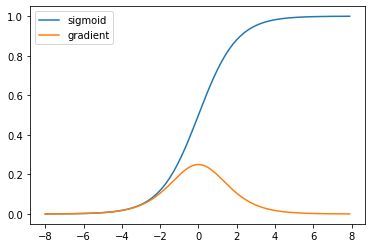

In [7]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach().numpy(), y.detach().numpy(),label='sigmoid')
plt.plot(x.detach().numpy(),x.grad.numpy(),'-',label='gradient')
plt.legend()

# 梯度爆炸
初始化的不合适会导致梯度爆炸，

In [8]:
M = torch.normal(0, 1, size=(4,4))
print('一个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print('乘以100个矩阵后\n', M)

一个矩阵 
 tensor([[-1.5956,  0.4891, -1.7372, -0.4619],
        [-2.1869,  0.7521,  0.6074,  0.4301],
        [ 0.8656, -0.0996,  1.0365,  0.8512],
        [ 2.0161, -0.5737, -1.0959,  0.3714]])
乘以100个矩阵后
 tensor([[-1.0406e+23,  1.0018e+23, -1.5189e+21, -1.6060e+22],
        [-1.4768e+23,  1.4218e+23, -2.1557e+21, -2.2793e+22],
        [ 6.7695e+22, -6.5175e+22,  9.8816e+20,  1.0448e+22],
        [ 1.6101e+23, -1.5501e+23,  2.3502e+21,  2.4850e+22]])


# 对称性
在神经网络设计过程中很容易是的$W_1$,$W_2$,产生相同的结果，网络相同的时候容易其所在位置可以互换。     
因此，打破对称性的方法就是对每层网络设置**dropout**来打破对称性

# 参数初始化
解决（或至少减轻）上述问题的一种方法是进行参数初始化，
优化期间的注意和适当的正则化也可以进一步提高稳定性。

### 默认初始化
**正态分布**来初始化权重值 

### Xavier初始化

让我们看看某些*没有非线性*的全连接层输出（例如，隐藏变量）$o_{i}$的尺度分布。
对于该层$n_\mathrm{in}$输入$x_j$及其相关权重$w_{ij}$，输出由下式给出

$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

权重$w_{ij}$都是从同一分布中独立抽取的。
此外，让我们假设该分布具有零均值和方差$\sigma^2$。
请注意，这并不意味着分布必须是高斯的，只是均值和方差需要存在。
现在，让我们假设层$x_j$的输入也具有零均值和方差$\gamma^2$，
并且它们独立于$w_{ij}$并且彼此独立。
在这种情况下，我们可以按如下方式计算$o_i$的平均值和方差：

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] \\&= 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

保持方差不变的一种方法是设置$n_\mathrm{in} \sigma^2 = 1$。
现在考虑反向传播过程，我们面临着类似的问题，尽管梯度是从更靠近输出的层传播的。
使用与前向传播相同的推断，我们可以看到，除非$n_\mathrm{out} \sigma^2 = 1$，
否则梯度的方差可能会增大，其中$n_\mathrm{out}$是该层的输出的数量。
这使得我们进退两难：我们不可能同时满足这两个条件。
相反，我们只需满足：

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ 或等价于 }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}.
\end{aligned}
$$

这就是现在标准且实用的*Xavier初始化*的基础，
它以其提出者 :cite:`Glorot.Bengio.2010` 第一作者的名字命名。
通常，Xavier初始化从均值为零，方差
$\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$
的高斯分布中采样权重。
我们也可以利用Xavier的直觉来选择从均匀分布中抽取权重时的方差。
注意均匀分布$U(-a, a)$的方差为$\frac{a^2}{3}$。
将$\frac{a^2}{3}$代入到$\sigma^2$的条件中，将得到初始化值域：

$$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).$$

尽管在上述数学推理中，“不存在非线性”的假设在神经网络中很容易被违反，
但Xavier初始化方法在实践中被证明是有效的。

## 小结

* 梯度消失和梯度爆炸是深度网络中常见的问题。在参数初始化时需要非常小心，以确保梯度和参数可以得到很好的控制。
* 需要用启发式的初始化方法来确保初始梯度既不太大也不太小。
* ReLU激活函数缓解了梯度消失问题，这样可以加速收敛。
* 随机初始化是保证在进行优化前打破对称性的关键。
* Xavier初始化表明，对于每一层，输出的方差不受输入数量的影响，任何梯度的方差不受输出数量的影响。

## 练习

1. 除了多层感知机的排列对称性之外，还能设计出其他神经网络可能会表现出对称性且需要被打破的情况吗？
2. 我们是否可以将线性回归或softmax回归中的所有权重参数初始化为相同的值？
3. 在相关资料中查找两个矩阵乘积特征值的解析界。这对确保梯度条件合适有什么启示？
4. 如果我们知道某些项是发散的，我们能在事后修正吗？看看关于按层自适应速率缩放的论文 :cite:`You.Gitman.Ginsburg.2017` 。
